In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import scipy.sparse as sp
import numpy as np
import torch 
from recommandation_propre import *
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

torch.set_default_tensor_type('torch.DoubleTensor')

# Préliminaires

In [2]:
def loadMovieLens(path='/data/movielens'):
    # Get movie titles
    movies={}
    for line in open(path+'/u.item'):
        (id,title)=line.split('|')[0:2]
        movies[id]=title
    # Load data
    prefs ={}
    for line in open(path+'/u.data'):
        (user,movieid,rating,ts)=line.split('\t')
        prefs.setdefault(user,{})
        prefs[user][movies[movieid]]=float(rating)
    return prefs

In [3]:
data = loadMovieLens('./ml-100k')

In [4]:
new = {}
for dic in data:
    new[int(dic)]=data[dic]

In [5]:
df = pd.DataFrame(new)

In [6]:
mtx = sp.csr_matrix(df.replace(np.nan, 0).values)

In [7]:
mtx

<1664x943 sparse matrix of type '<class 'numpy.float64'>'
	with 99693 stored elements in Compressed Sparse Row format>

# Visualisation des données

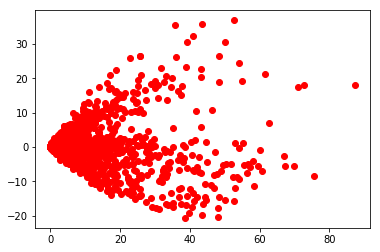

In [8]:
svd_films = TruncatedSVD()
svd_films.fit(mtx)
red_mtx_films = svd_films.fit_transform(mtx)

plt.plot(red_mtx_films[:,0],red_mtx_films[:,1],'ro')
plt.show()

[0.15435838 0.04821754]


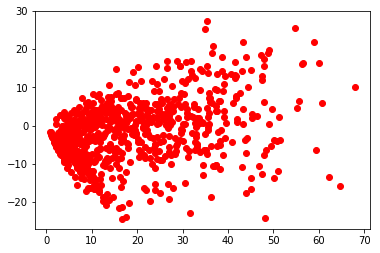

In [9]:
svd_users = TruncatedSVD()
svd_users.fit(mtx.transpose())
red_mtx_users = svd_users.fit_transform(mtx.transpose())

print(svd_users.explained_variance_ratio_)

plt.plot(red_mtx_users[:,0],red_mtx_users[:,1],'ro')
plt.show()

#  Set de données

In [22]:
df_train ,test = cut_train_test(df)

length test : 2472.0
ration test/train: 0.02546196155985415


#  Base Line

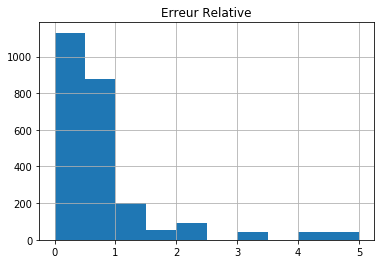

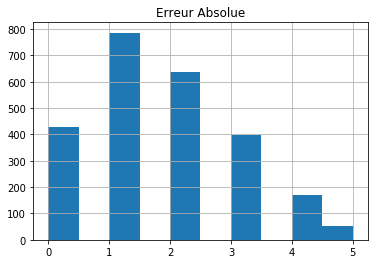

In [41]:
rec_rand = Recommandation()
df_rel = rec_rand.random_score(test, rel_error)
df_abs = rec_rand.random_score(test, abs_error)

df_rel.columns = ['Erreur Relative']
df_abs.columns = ['Erreur Absolue']

df_rel.hist()
df_abs.hist()

df_results = pd.concat([df_rel.describe(),df_abs.describe()], axis = 1)
writer = pd.ExcelWriter('random_scores.xlsx')
df_results.to_excel(writer,'Sheet1')
writer.save()

In [34]:
note_mean = df_train.mean().mean()

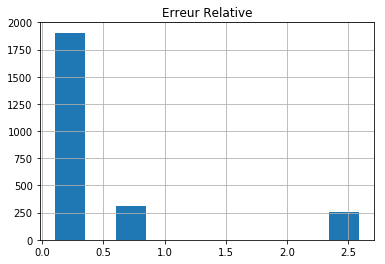

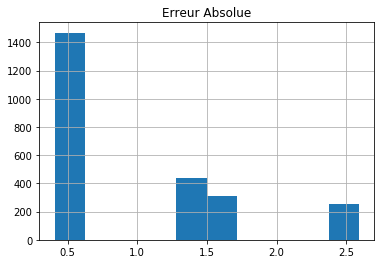

In [42]:
rec_cst = Recommandation()
df_rel = rec_rand.cst_score(test, note_mean,rel_error)
df_abs = rec_rand.cst_score(test, note_mean,abs_error)

df_rel.columns = ['Erreur Relative']
df_abs.columns = ['Erreur Absolue']

df_rel.hist()
df_abs.hist()

df_results = pd.concat([df_rel.describe(),df_abs.describe()], axis = 1)
writer = pd.ExcelWriter('cst_scores.xlsx')
df_results.to_excel(writer,'Sheet1')
writer.save()

In [32]:
pd.concat([df_rel,df_abs], axis = 1)

,0,0
count,2472.000000,2472.000000
mean,0.506451,1.011979
std,0.741640,0.702501
min,0.101940,0.407761
25%,0.101940,0.407761
50%,0.197413,0.592239
75%,0.281552,1.407761
max,2.592239,2.592239


# Question 1

In [13]:
model_svd = TruncatedSVD(n_components=25,n_iter=2)
rec_syst_svd = Recommandation(model_svd)
rec_syst_svd.fit(df_train)

In [14]:
rec_syst_svd.score(test, rel_error)

,0
count,2607.000000
mean,0.749821
std,0.290719
min,0.000000
25%,0.600000
50%,0.800000
75%,1.000000
max,2.000000


# Question 2

In [15]:
model_nmf = NMF(n_components=25, init='random', random_state=0)
rec_syst_nmf = Recommandation(model_nmf)
rec_syst_nmf.fit(df_train)

In [16]:
rec_syst_nmf.score(test, rel_error)

,0
count,2607.000000
mean,0.749022
std,0.298211
min,0.000000
25%,0.500000
50%,0.800000
75%,1.000000
max,2.000000


#  Question 3

Source : https://tel.archives-ouvertes.fr/tel-01005223/document

## Sans L2

In [44]:
dim = 2
epsilon = 1e-3
reg_q = 0
reg_p = 0
max_iter = 5

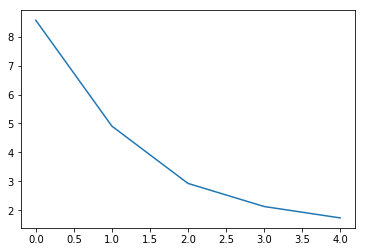

In [45]:
rec_syst = Recommandation()
cost, res_test = rec_syst.fit_SGD_stoch(df_train, dim, epsilon, reg_q, reg_p, max_iter,test)

plt.plot(range(len(cost)),cost)
plt.show()
plt.plot(range(len(res_test)),res_test)
plt.show()

In [46]:
rec_syst.score(test, rel_error)

,0
count,2606.000000
mean,0.395568
std,0.363159
min,0.000000
25%,0.000000
50%,0.333333
75%,0.600000
max,3.000000


## Avec L2

In [66]:
dim = 2
epsilon = 1e-3
reg_q = 0.001
reg_p = 0.001
max_iter = 5

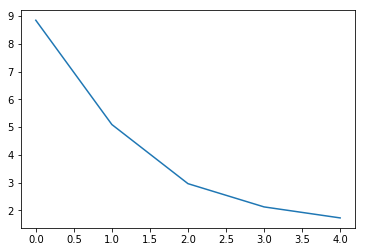

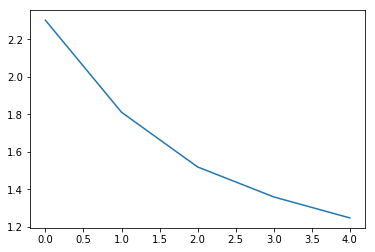

In [67]:
rec_syst = Recommandation()
cost,res_test = rec_syst.fit_SGD_stoch(df_train, dim, epsilon, reg_q, reg_p, max_iter,test)

plt.plot(range(len(cost)),cost)
plt.show()

plt.plot(range(len(res_test)),res_test)
plt.show()

In [57]:
rec_syst.score(test, rel_error)

,0
count,2606.000000
mean,0.405871
std,0.370889
min,0.000000
25%,0.200000
50%,0.333333
75%,0.600000
max,3.000000


# Question 4

In [8]:
dim = 2
epsilon = 1e-3
reg_q = 0
reg_p = 0
max_iter = 5

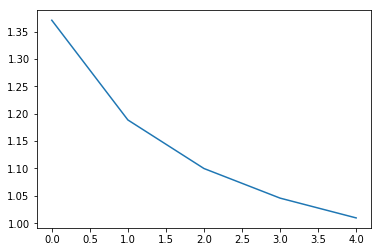

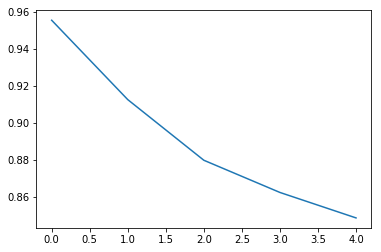

In [23]:
rec_syst_biais = Recommandation()
cost,res_test = rec_syst_biais.fit_SGD_stoch_biais(df_train, dim, epsilon, reg_q, reg_p, max_iter,test)

plt.plot(range(len(cost)),cost)
plt.show()

plt.plot(range(len(res_test)),res_test)
plt.show()

In [25]:
rec_syst_biais.score_biais(test, rel_error)

,0
count,2472.000000
mean,0.394822
std,0.593209
min,0.000000
25%,0.000000
50%,0.250000
75%,0.400000
max,3.000000


In [26]:
df

,196,186,22,244,166,298,115,253,305,6,...,925,942,937,926,943,939,936,930,920,941
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-900 (1994),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187 (1997),NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2 Days in the Valley (1996),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,4.0,NaN,NaN,NaN
"20,000 Leagues Under the Sea (1954)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001: A Space Odyssey (1968),NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,5.0,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3 Ninjas: High Noon At Mega Mountain (1998),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"39 Steps, The (1935)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
str(abs_error)

'<function abs_error at 0x0000027AB2ED3598>'